## Exercise 1: Cracking the SHA-1 Hash

The provided script successfully cracked the SHA-1 hash.

The password is **'ThaiLanD'**.

The script found this by testing words from a dictionary. It applied common variations like different capitalization and character substitutions (e.g., 'a' for '4'). This process is known as a dictionary attack.

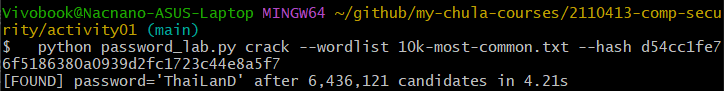

---

## Exercise 2: Hashing Algorithm Performance

The goal was to measure how many hashes different algorithms can compute in a set time. The results show a major difference in speed.

- **MD5**: ~1.7 million hashes/second
- **SHA1**: ~1.8 million hashes/second
- **BCRYPT**: 6 hashes/second

This experiment shows why modern algorithms like **bcrypt** are more secure. They are intentionally slow. Fast algorithms like MD5 and SHA-1 allow attackers to guess billions of passwords very quickly.

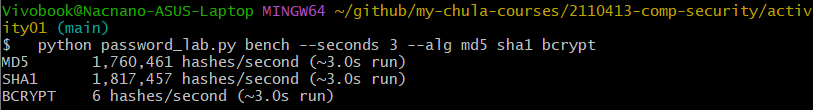

---

## Exercise 3: Brute-Force Time Estimation

This exercise estimated the time to brute-force a password based on its length. The results assume an attacker can test 200 million hashes per second.

- **Length 8**: ~352 days
- **Length 10**: ~8,539 years
- **Length 12**: ~75.4 million years

This shows that **password length** is critical for security. A password should be long enough to take more than a year to crack. Based on these results, a password of at least **10 to 12 characters** is recommended.

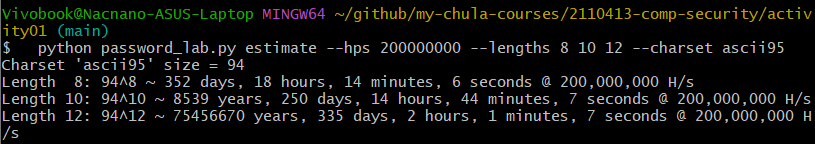

---

## Question 4: Brute-Forcing Bcrypt

No, a brute-force attack on a **bcrypt** hash is **not practical**.

As seen in the benchmark, bcrypt is extremely slow. An attacker can only test a few passwords per second. This makes guessing every possible combination an impossibly long process.

---

## Question 5: Rainbow Table Attack on Bcrypt

No, a rainbow table attack is also **not practical** against bcrypt.

Bcrypt automatically incorporates a random value called a **salt** into each hash. This salt is different for every password. Therefore, an attacker cannot use a single pre-computed rainbow table. They would need a separate, massive table for every single user, which is not feasible.

---

## Question 6: Secure Password Storage Design

- **Use a Proper Hash Function**: Always use a modern, slow algorithm designed for passwords, such as **bcrypt**, scrypt, or Argon2. Avoid MD5 and SHA-1.
- **Use Salting**: A unique, random salt must be generated for each password and stored with the hash. This is a core feature of bcrypt and defends against rainbow table attacks.
- **Use a Cost Factor**: The "slowness" of bcrypt can be adjusted. You should configure this cost factor to be as high as your servers can handle without creating a bad user experience.
- **Secure the Database**: Protect the database itself with strong access controls and encryption. Even perfectly hashed passwords are at risk if the entire database is stolen.

## Python code for all exercises

In [ ]:
"""
Computer Security Lab — Activity I: Hacking Passwords
Author: Nacnano
Python 3.11

Usage examples:
  python password_lab.py crack --wordlist 10k-most-common.txt --hash d54cc1fe76f5186380a0939d2fc1723c44e8a5f7
  python password_lab.py bench --seconds 3 --alg md5 sha1 bcrypt
  python password_lab.py estimate --hps 200000000 --lengths 8 10 12 --charset ascii95

Notes:
- Install bcrypt if you want bcrypt benchmarks: pip install bcrypt
- Wordlist can be the 10k list: https://github.com/danielmiessler/SecLists/blob/master/Passwords/Common-Credentials/10k-most-common.txt
"""

import argparse, hashlib, time, sys, os, math, itertools, string

SUBS = {
    "o": ["0"],
    "l": ["1"],
    "i": ["1", "!"],
    "a": ["4"],
    "e": ["3"],
    "s": ["5"],
    "t": ["7"],
}

SUFFIXES = ["", "1", "12", "123", "1234", "12345", "!", "!23", "2024", "2025"]


def gen_variants(word: str):
    """
    Generate casing + leetspeak + common suffix variants for a word.
    Uses itertools.product for all possible substitutions.
    """
    # Build list of possible options per character
    chars_options: list[list[str]] = []

    for ch in word:
        # base: lowercase + uppercase (if alpha)
        opts = [ch.lower(), ch.upper()] if ch.isalpha() else [ch]

        # add substitutions if applicable
        if ch.lower() in SUBS:
            opts.extend(SUBS[ch.lower()])

        chars_options.append(list(set(opts)))  # dedupe

    # Cartesian product: all possible variants
    for combo in itertools.product(*chars_options):
        base = "".join(combo)
        for suf in SUFFIXES:
            yield base + suf


def sha1_hex(s: bytes) -> str:
    return hashlib.sha1(s).hexdigest()

def crack_sha1(wordlist_path: str, target_hex: str):
    """Exercise 1: dictionary + substitutions against SHA-1 hash."""
    tried = 0
    start = time.time()
    with open(wordlist_path, "rb") as f:
        for raw in f:
            raw = raw.strip()
            if not raw:
                continue
            try:
                w = raw.decode("utf-8", errors="ignore")
            except Exception:
                continue
            for cand in gen_variants(w):
                tried += 1
                if hashlib.sha1(cand.encode()).hexdigest() == target_hex:
                    dur = time.time() - start
                    print(f"[FOUND] password='{cand}' after {tried:,} candidates in {dur:.2f}s")
                    return True
    print(f"[NOT FOUND] after {tried:,} candidates in {time.time()-start:.2f}s")
    return False

def bench_hash(alg: str, seconds: float = 2.0):
    """Exercise 2: simple throughput benchmark for MD5/SHA-1/bcrypt."""
    data = b"benchmark-input"
    count = 0
    start = time.time()
    if alg.lower() in ("md5", "sha1", "sha256", "sha512"):
        hfunc = getattr(hashlib, alg.lower())
        while time.time() - start < seconds:
            hfunc(data).hexdigest()
            count += 1
        hps = count / max(time.time() - start, 1e-9)
        return hps
    elif alg.lower() == "bcrypt":
        try:
            import bcrypt
        except Exception as e:
            print("bcrypt not available. Install with: pip install bcrypt")
            return None
        # Choose a moderate cost (rounds) to keep the demo quick.
        cost = int(os.environ.get("BCRYPT_COST", "12"))
        salt = bcrypt.gensalt(rounds=cost)
        while time.time() - start < seconds:
            bcrypt.hashpw(data, salt)
            count += 1
        hps = count / max(time.time() - start, 1e-9)
        return hps
    else:
        raise ValueError(f"Unknown algorithm: {alg}")

CHARSETS = {
    "digits": string.digits,
    "lower26": string.ascii_lowercase,
    "upper26": string.ascii_uppercase,
    "letters52": string.ascii_letters,
    "alnum62": string.ascii_letters + string.digits,
    "ascii95": string.ascii_letters + string.digits + string.punctuation,  # 95 printable
}

def estimate_bruteforce_time(hps: float, length: int, charset: str = "ascii95"):
    """Exercise 3: expected brute-force time (exhaustive search, single worker)."""
    N = len(CHARSETS[charset]) ** length
    seconds = N / max(hps, 1e-12)
    return seconds

def human_time(seconds: float):
    units = [("years", 365*24*3600), ("days", 24*3600), ("hours", 3600), ("minutes", 60), ("seconds", 1)]
    parts = []
    remain = seconds
    for name, unit in units:
        if remain >= unit:
            qty = int(remain // unit)
            parts.append(f"{qty} {name}")
            remain -= qty * unit
    if not parts:
        return f"{seconds:.3f} seconds"
    return ", ".join(parts)

def main():
    ap = argparse.ArgumentParser()
    sub = ap.add_subparsers(dest="cmd", required=True)

    sp = sub.add_parser("crack", help="Exercise 1: crack SHA-1 with dictionary+substitutions")
    sp.add_argument("--wordlist", required=True, help="Path to word list file (one candidate per line)")
    sp.add_argument("--hash", required=True, help="Target SHA-1 hex")
    
    sb = sub.add_parser("bench", help="Exercise 2: benchmark hashing throughput")
    sb.add_argument("--seconds", type=float, default=2.0, help="Seconds per algorithm")
    sb.add_argument("--alg", nargs="+", help="Algorithms to test: md5 sha1 sha256 sha512 bcrypt")

    se = sub.add_parser("estimate", help="Exercise 3: brute-force time estimates")
    se.add_argument("--hps", type=float, required=True, help="Hashes per second (from your benchmark)")
    se.add_argument("--charset", choices=list(CHARSETS.keys()), default="ascii95")
    se.add_argument("--lengths", type=int, nargs="+", required=True)

    args = ap.parse_args()

    if args.cmd == "crack":
        ok = crack_sha1(args.wordlist, args.hash)
        sys.exit(0 if ok else 1)

    if args.cmd == "bench":
        for alg in args.alg:
            hps = bench_hash(alg, args.seconds)
            if hps is None:
                print(f"{alg.upper():<8}  -  (bcrypt not installed)")
            else:
                print(f"{alg.upper():<8}  {hps:,.0f} hashes/second (~{args.seconds}s run)")
        return

    if args.cmd == "estimate":
        print(f"Charset '{args.charset}' size = {len(CHARSETS[args.charset])}")
        for L in args.lengths:
            secs = estimate_bruteforce_time(args.hps, L, args.charset)
            print(f"Length {L:>2}: {len(CHARSETS[args.charset])}^{L} ~ {human_time(secs)} @ {args.hps:,.0f} H/s")
        return

if __name__ == "__main__":
    main()
